In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from odes import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *

Initialisation of parametres

In [2]:
def sim_run(N, M, para, assemblenum, tstop, teval):

    ### initialised parametres
    para = Paras(N, M)
    p, number = int_preferences(N, M, para.mu_c, assemblenum)
    D = int_conversion(M, para.Dbase, assemblenum)
    l = int_l(M, para.l_base, assemblenum)
    rho = int_rho(M, para.rho_base, assemblenum)
    vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
    m = int_mt(N, para.m_base, assemblenum)

    ## Initialised Initial conditions
    R0 = int_R(M, para.R0, assemblenum)
    C0 = int_C(N, para.w, assemblenum)

    # Load parametres
    para.paras(C0, R0, l, rho, p, vmax, m, D)
    time = np.linspace(0, tstop, teval)
    pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.gamma, para.R_half)
    y0 = np.concatenate((R0, C0)).reshape(M+N,) # initial conditions

    # run and store
    result = solve_ivp(
    odes_scale_size, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)

    Rt = result['y'][0:M]
    Ct = result['y'][M:M+N]
    t = result['t']

    return Rt, Ct, t, para
    

In [37]:
N = 25
M = 50
assemblenum = 1
para = Paras(N, M)

In [38]:
Rt_assemblies = []
Ct_assemblies = []
assemlies = 100
para_assemblies = []

In [39]:
for i in range(assemlies):
    Rt, Ct, t, para = sim_run(N, M, para, i, tstop=4000, teval=10000)
    Rt_assemblies.append(Rt)
    Ct_assemblies.append(Ct)
    para_assemblies.append(para)

In [40]:
t.shape

(10000,)

In [41]:
Rt.shape

(50, 10000)

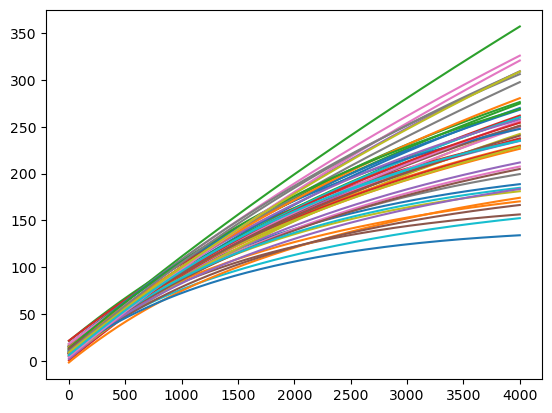

In [42]:
for i in range(M):
    plt.plot(t, Rt[i, :])

In [43]:
# for j in range(100):
#     for i in range(N):
#         Ct = Ct_assemblies[j]
#         plt.plot(t, Ct[i, :])

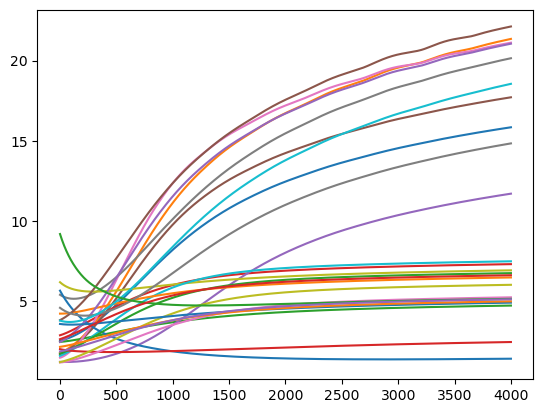

In [45]:
for i in range(N):
        #Ct = Ct_assemblies[j]
        plt.plot(t, Ct[i, :])

In [22]:
mass = Ct_assemblies[i]
mass[:, 1]

array([2.68998362, 1.03515615, 2.78846296, 3.40638701, 1.34545352,
       3.66163265, 4.03940835, 7.00159911, 1.15572569, 3.08056181,
       1.21665493, 5.25617715, 2.11056596, 1.85045596, 1.12143932,
       1.39113172, 5.48471459, 1.34197479, 4.61354047, 2.26651801,
       3.94082879, 1.41750175, 1.81820839, 5.58530295, 3.83749142,
       2.21567509, 1.5104088 , 1.850768  , 2.78619946, 2.1117636 ,
       2.18248499, 2.3906028 , 1.62152398, 4.07342682, 3.73213231,
       6.14820035, 1.82632154, 1.22299567, 1.71929312, 2.65043482,
       3.34562059, 5.00748285, 1.51209043, 1.55052392, 3.06959187,
       7.28263537, 1.90825598, 1.66045449, 7.00313426, 6.20520571])

In [23]:
initial = np.empty((N*100))
final = np.empty((N*100))
for i in range(len(para_assemblies)):
    model = para_assemblies[i]
    initial[i*N:(i+1)*N] = model.C.reshape(50)
    mass = Ct_assemblies[i]
    final[i*N:(i+1)*N] = mass[:, 1]


(array([2349., 1053.,  639.,  343.,  252.,  176.,   88.,   53.,   32.,
          15.]),
 array([1.00156256, 1.87408983, 2.74661709, 3.61914435, 4.49167162,
        5.36419888, 6.23672615, 7.10925341, 7.98178067, 8.85430794,
        9.7268352 ]),
 <BarContainer object of 10 artists>)

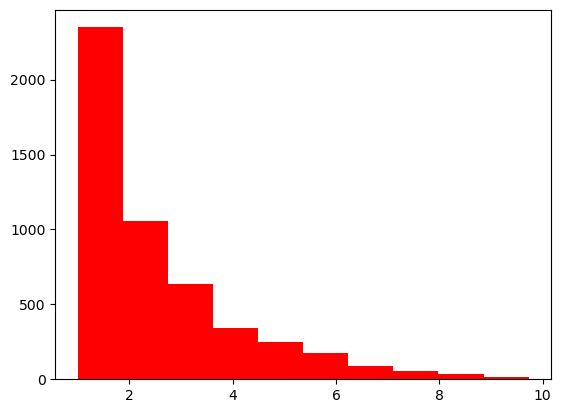

In [27]:
plt.hist(final, label='final', color='red')

(array([2350., 1052.,  640.,  343.,  251.,  176.,   88.,   53.,   33.,
          14.]),
 array([1.00062655, 1.87409436, 2.74756217, 3.62102998, 4.49449779,
        5.3679656 , 6.24143341, 7.11490122, 7.98836903, 8.86183684,
        9.73530465]),
 <BarContainer object of 10 artists>)

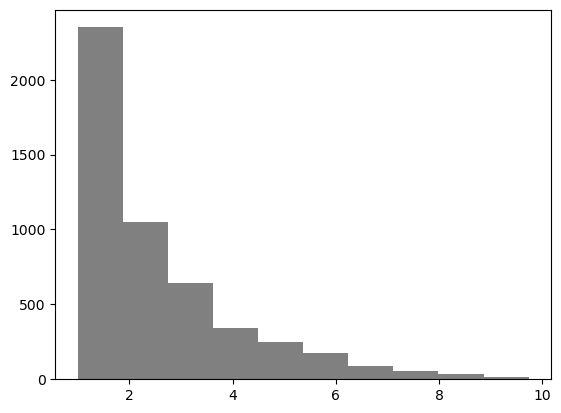

In [28]:
plt.hist(initial, label='initial distirbution', color='grey')

In [11]:
Rt.shape

(100, 10000)

In [12]:
species1vg = []

In [13]:
Ct[:, i]

array([2.56346768, 1.77378887, 2.46282479, 2.94353672, 1.21118735,
       1.70036977, 1.51239909, 5.24189803, 6.04524456, 1.65523473,
       5.47103989, 4.17215387, 1.79340998, 2.01808125, 2.49201539,
       3.93746508, 1.17699549, 4.50567248, 1.20662486, 3.76896656,
       3.53440511, 2.15566703, 8.80294367, 2.71766004, 1.8568812 ,
       1.2557053 , 2.40885739, 1.62338412, 2.54497018, 1.39065106,
       5.59593259, 4.24554162, 1.6773773 , 1.6883716 , 2.21018409,
       1.67692756, 1.1109172 , 2.21572204, 1.10129189, 3.50168574,
       1.8662144 , 1.83772337, 1.02675009, 1.55251679, 2.51853183,
       2.39774428, 1.19242723, 8.00236666, 2.25020186, 1.53375475])

Text(0.5, 0, 'Time')

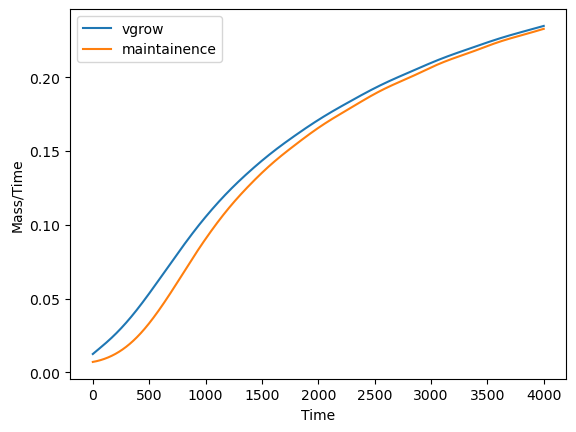

In [14]:
species1vg = []
m1 = []
for i in range(len(t)):
    resourcet = Rt[:, i].reshape(M, 1)
    masst = Ct[:, i].reshape(N, 1)
    v_in = vin(para.p, resourcet, para.R_half, vmax=para.v_in_max, type=2)
    v_in = scale_vin(v_in, masst, para.B0, para.alpha)
    v_g = vgrow(v_in, para.l)
    v_g = v_g * masst
    species1vg.append(v_g[0])
    m_scale = scale_mt(para.m, masst, para.M0, para.alpha)
    m_scale = m_scale * masst
    m1.append(m_scale[0])
    

plt.plot(t, species1vg, label = 'vgrow')
plt.plot(t, m1, label='maintainence')
plt.legend()
plt.ylabel('Mass/Time')
plt.xlabel('Time')

In [15]:
np.sign(-7)

-1